# Sentiment Analysis

## Using XGBoost in SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

As our first example of using Amazon's SageMaker service we will construct a random tree model to predict the sentiment of a movie review. You may have seen a version of this example in a pervious lesson although it would have been done using the sklearn package. Instead, we will be using the XGBoost package as it is provided to us by Amazon.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there may be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## Step 1: Downloading the data

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

We begin by using some Jupyter Notebook magic to download and extract the dataset.

In [1]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

--2020-04-19 00:14:24--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  23.1MB/s    in 4.8s    

2020-04-19 00:14:29 (16.7 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing the data

The data we have downloaded is split into various files, each of which contains a single review. It will be much easier going forward if we combine these individual files into two large files, one for training and one for testing.

In [2]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [3]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [4]:
type(data)

dict

In [5]:
len(data['train']['pos'])

12500

In [6]:
data['train']['pos'][0]

'While traveling by train through Europe, the American Jesse (Ethan Hawke) and the French Celine (Julie Delpy) meet each other and decide to spend the night together in Austria. On the next morning, Jesse returns to United States of America, and Celine to Paris. <br /><br />"Before Sunrise" is one of my favorite romances, indeed one of the most beautiful love stories I have ever seen. It is a low budget movie with a very simple and real storyline, but the chemistry between Ethan Hawke and Julie Delpy is perfect, and the dialogs are stunning. The direction is amazing, transmitting the feelings of Celine and Jesse to the viewer. I have just completed my review number 1,000 in IMDb, and I choose "Before Sunrise" for this significant number because it is a very special film for me. I cannot understand why this movie was not nominated to the Oscar, with such a magnificent screenplay, direction and performances. Yesterday I have probably watched this movie for the third or fourth time, and I

In [7]:
labels['train']['pos'][0]

1

In [8]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train, random_state=999)
    data_test, labels_test = shuffle(data_test, labels_test, random_state=999)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [9]:
# 0 means preprocessed
train_X0, test_X0, train_y0, test_y0 = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X0), len(test_X0)))

IMDb reviews (combined): train = 25000, test = 25000


In [10]:
train_X0[555]

"Ultimately too silly and pointless. Yes there is the gilded cage metaphor but probably most kids would miss that. Forgettable. Instantly.<br /><br />Animation is, as we have come to expect, super-real. The plot-line could best be described as thin but tenacious. Although the ending seemed arbitrary to me.<br /><br />The sewer underworld is a suitably disgusting reflection of the world above and, somehow, wealth and money seem to count for a lot there too. Oh yes, and there's a romantic interest with the female being the smarter, more savvy and go-getting of the pair - this in itself is rapidly becoming a tiresome (anti) stereotype. Probably your kids will love it though."

In [11]:
train_y0[555]

0

In [12]:
type(train_X0)

list

## Step 3: Processing the data

Now that we have our training and testing datasets merged and ready to use, we need to start processing the raw data into something that will be useable by our machine learning algorithm. To begin with, we remove any html formatting that may appear in the reviews and perform some standard natural language processing in order to homogenize the data.

In [13]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
import re
from bs4 import BeautifulSoup

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [15]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [16]:
%%time
# Preprocess data
# X1 means after processed
train_X1, test_X1, train_y1, test_y1 = preprocess_data(train_X0, test_X0, train_y0, test_y0)

Wrote preprocessed data to cache file: preprocessed_data.pkl
CPU times: user 25min 53s, sys: 1min 31s, total: 27min 24s
Wall time: 27min 24s


In [17]:
type(train_X1)

list

In [18]:
print(train_X1[555])
print('')
print(train_X0[555])

['ultim', 'silli', 'pointless', 'ye', 'gild', 'cage', 'metaphor', 'probabl', 'kid', 'would', 'miss', 'forgett', 'instantli', 'anim', 'come', 'expect', 'super', 'real', 'plot', 'line', 'could', 'best', 'describ', 'thin', 'tenaci', 'although', 'end', 'seem', 'arbitrari', 'sewer', 'underworld', 'suitabl', 'disgust', 'reflect', 'world', 'somehow', 'wealth', 'money', 'seem', 'count', 'lot', 'oh', 'ye', 'romant', 'interest', 'femal', 'smarter', 'savvi', 'go', 'get', 'pair', 'rapidli', 'becom', 'tiresom', 'anti', 'stereotyp', 'probabl', 'kid', 'love', 'though']

Ultimately too silly and pointless. Yes there is the gilded cage metaphor but probably most kids would miss that. Forgettable. Instantly.<br /><br />Animation is, as we have come to expect, super-real. The plot-line could best be described as thin but tenacious. Although the ending seemed arbitrary to me.<br /><br />The sewer underworld is a suitably disgusting reflection of the world above and, somehow, wealth and money seem to count

### Extract Bag-of-Words features

For the model we will be implementing, rather than using the reviews directly, we are going to transform each review into a Bag-of-Words feature representation. Keep in mind that 'in the wild' we will only have access to the training set so our transformer can only use the training set to construct a representation.

In [19]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

In [20]:
%%time
# Extract Bag of Words features for both training and test datasets
train_X2, test_X2, vocabulary = extract_BoW_features(train_X1, test_X1)

Wrote features to cache file: bow_features.pkl
CPU times: user 3.85 s, sys: 2.12 s, total: 5.96 s
Wall time: 6 s


In [21]:
type(train_X2)

numpy.ndarray

In [22]:
train_X = train_X2
train_y = train_y1

test_X = test_X2
test_y = test_y1

In [23]:
print(train_X0[555])
print('')
print(train_X1[555])
print('')
print(train_X[555])

Ultimately too silly and pointless. Yes there is the gilded cage metaphor but probably most kids would miss that. Forgettable. Instantly.<br /><br />Animation is, as we have come to expect, super-real. The plot-line could best be described as thin but tenacious. Although the ending seemed arbitrary to me.<br /><br />The sewer underworld is a suitably disgusting reflection of the world above and, somehow, wealth and money seem to count for a lot there too. Oh yes, and there's a romantic interest with the female being the smarter, more savvy and go-getting of the pair - this in itself is rapidly becoming a tiresome (anti) stereotype. Probably your kids will love it though.

['ultim', 'silli', 'pointless', 'ye', 'gild', 'cage', 'metaphor', 'probabl', 'kid', 'would', 'miss', 'forgett', 'instantli', 'anim', 'come', 'expect', 'super', 'real', 'plot', 'line', 'could', 'best', 'describ', 'thin', 'tenaci', 'although', 'end', 'seem', 'arbitrari', 'sewer', 'underworld', 'suitabl', 'disgust', 'ref

In [24]:
train_X.shape

(25000, 5000)

In [25]:
type(train_X)

numpy.ndarray

## Step 4: Classification using XGBoost

Now that we have created the feature representation of our training (and testing) data, it is time to start setting up and using the XGBoost classifier provided by SageMaker.

### (TODO) Writing the dataset

The XGBoost classifier that we will be using requires the dataset to be written to a file and stored using Amazon S3. To do this, we will start by splitting the training dataset into two parts, the data we will train the model with and a validation set. Then, we will write those datasets to a file and upload the files to S3. In addition, we will write the test set input to a file and upload the file to S3. This is so that we can use SageMakers Batch Transform functionality to test our model once we've fit it.

In [26]:
import pandas as pd

# TODO: Split the train_X and train_y arrays into the DataFrames val_X, train_X and val_y, train_y. Make sure that
#       val_X and val_y contain 10 000 entires while train_X and train_y contain the remaining 15 000 entries.

val_X = pd.DataFrame(train_X[:10000])
train_X = pd.DataFrame(train_X[10000:])

val_y = pd.DataFrame(train_y[:10000])
train_y = pd.DataFrame(train_y[10000:])

In [27]:
train_X.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The documentation for the XGBoost algorithm in SageMaker requires that the saved datasets should contain no headers or index and that for the training and validation data, the label should occur first for each sample.

For more information about this and other algorithms, the SageMaker developer documentation can be found on __[Amazon's website.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [28]:
# First we make sure that the local directory in which we'd like to store the training and validation csv files exists.
data_dir = '../data/xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [29]:
# First, save the test data to test.csv in the data_dir directory. Note that we do not save the associated ground truth
# labels, instead we will use them later to compare with our model output.

pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# TODO: Save the training and validation data to train.csv and validation.csv in the data_dir directory.
#       Make sure that the files you create are in the correct format.

pd.concat([val_y, val_X], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([train_y, train_X], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [30]:
# To save a bit of memory we can set text_X, train_X, val_X, train_y and val_y to None.

test_X = train_X = val_X = train_y = val_y = None

### (TODO) Uploading Training / Validation files to S3

Amazon's S3 service allows us to store files that can be access by both the built-in training models such as the XGBoost model we will be using as well as custom models such as the one we will see a little later.

For this, and most other tasks we will be doing using SageMaker, there are two methods we could use. The first is to use the low level functionality of SageMaker which requires knowing each of the objects involved in the SageMaker environment. The second is to use the high level functionality in which certain choices have been made on the user's behalf. The low level approach benefits from allowing the user a great deal of flexibility while the high level approach makes development much quicker. For our purposes we will opt to use the high level approach although using the low-level approach is certainly an option.

Recall the method `upload_data()` which is a member of object representing our current SageMaker session. What this method does is upload the data to the default bucket (which is created if it does not exist) into the path described by the key_prefix variable. To see this for yourself, once you have uploaded the data files, go to the S3 console and look to see where the files have been uploaded.

For additional resources, see the __[SageMaker API documentation](http://sagemaker.readthedocs.io/en/latest/)__ and in addition the __[SageMaker Developer Guide.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [31]:
import sagemaker

session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'sentiment-xgboost'

# TODO: Upload the test.csv, train.csv and validation.csv files which are contained in data_dir to S3 using sess.upload_data().
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### (TODO) Creating the XGBoost model

Now that the data has been uploaded it is time to create the XGBoost model. To begin with, we need to do some setup. At this point it is worth discussing what a model is in SageMaker. It is easiest to think of a model of comprising three different objects in the SageMaker ecosystem, which interact with one another.

- Model Artifacts
- Training Code (Container)
- Inference Code (Container)

The Model Artifacts are what you might think of as the actual model itself. For example, if you were building a neural network, the model artifacts would be the weights of the various layers. In our case, for an XGBoost model, the artifacts are the actual trees that are created during training.

The other two objects, the training code and the inference code are then used the manipulate the training artifacts. More precisely, the training code uses the training data that is provided and creates the model artifacts, while the inference code uses the model artifacts to make predictions on new data.

The way that SageMaker runs the training and inference code is by making use of Docker containers. For now, think of a container as being a way of packaging code up so that dependencies aren't an issue.

In [32]:
from sagemaker import get_execution_role

# Our current execution role is require when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()

In [33]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost',  '0.90-1')

In [34]:
# TODO: Create a SageMaker estimator using the container location determined in the previous cell.
#       It is recommended that you use a single training instance of type ml.m4.xlarge. It is also
#       recommended that you use 's3://{}/{}/output'.format(session.default_bucket(), prefix) as the
#       output path.

xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)


# TODO: Set the XGBoost hyperparameters in the xgb object. Don't forget that in this case we have a binary
#       label so we should be using the 'binary:logistic' objective.

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the XGBoost model

Now that our model has been set up we simply need to attach the training and validation datasets and then ask SageMaker to set up the computation.

In [35]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [36]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-04-19 00:47:04 Starting - Starting the training job...
2020-04-19 00:47:06 Starting - Launching requested ML instances............
2020-04-19 00:49:09 Starting - Preparing the instances for training......
2020-04-19 00:50:12 Downloading - Downloading input data...
2020-04-19 00:51:02 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[00:51:07] 15000x5000 matrix with 75000000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimite

[110]#011train-error:0.103333#011validation-error:0.1463
[111]#011train-error:0.103#011validation-error:0.1456
[112]#011train-error:0.102#011validation-error:0.1454
[113]#011train-error:0.102067#011validation-error:0.1456
[114]#011train-error:0.101067#011validation-error:0.1455
[115]#011train-error:0.101133#011validation-error:0.1453
[116]#011train-error:0.100867#011validation-error:0.1452
[117]#011train-error:0.1008#011validation-error:0.1445
[118]#011train-error:0.101#011validation-error:0.1439
[119]#011train-error:0.100467#011validation-error:0.1431
[120]#011train-error:0.099733#011validation-error:0.1425
[121]#011train-error:0.099333#011validation-error:0.142
[122]#011train-error:0.099133#011validation-error:0.1418
[123]#011train-error:0.098667#011validation-error:0.1416
[124]#011train-error:0.098#011validation-error:0.1422
[125]#011train-error:0.098067#011validation-error:0.1423
[126]#011train-error:0.097533#011validation-error:0.1419
[127]#011train-error:0.096733#011validation-er

### (TODO) Testing the model

Now that we've fit our XGBoost model, it's time to see how well it performs. To do this we will use SageMakers Batch Transform functionality. Batch Transform is a convenient way to perform inference on a large dataset in a way that is not realtime. That is, we don't necessarily need to use our model's results immediately and instead we can peform inference on a large number of samples. An example of this in industry might be peforming an end of month report. This method of inference can also be useful to us as it means to can perform inference on our entire test set. 

To perform a Batch Transformation we need to first create a transformer objects from our trained estimator object.

In [37]:
%%time
# TODO: Create a transformer object from the trained model. Using an instance count of 1 and an instance type of ml.m4.xlarge
#       should be more than enough.
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

CPU times: user 11 ms, sys: 7.72 ms, total: 18.7 ms
Wall time: 376 ms


Next we actually perform the transform job. When doing so we need to make sure to specify the type of data we are sending so that it is serialized correctly in the background. In our case we are providing our model with csv data so we specify `text/csv`. Also, if the test data that we have provided is too large to process all at once then we need to specify how the data file should be split up. Since each line is a single entry in our data set we tell SageMaker that it can split the input on each line.

In [38]:
%%time
# TODO: Start the transform job. Make sure to specify the content type and the split type of the test data.
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

CPU times: user 7.84 ms, sys: 108 µs, total: 7.95 ms
Wall time: 306 ms


Currently the transform job is running but it is doing so in the background. Since we wish to wait until the transform job is done and we would like a bit of feedback we can run the `wait()` method.

In [39]:
%%time
xgb_transformer.wait()

.....................[2020-04-19 00:57:40 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-04-19 00:57:40 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-04-19 00:57:40 +0000] [15] [INFO] Using worker: gevent
[2020-04-19 00:57:40 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-19 00:57:40 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-19 00:57:40 +0000] [24] [INFO] Booting worker with pid: 24
[2020-04-19 00:57:40 +0000] [28] [INFO] Booting worker with pid: 28
[2020-04-19:00:58:06:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:00:58:06 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-04-19:00:58:06:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:00:58:06 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-04-19:00:58:06:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:00:58:06 +0000] "GET /execution-paramete

169.254.255.130 - - [19/Apr/2020:00:58:32 +0000] "POST /invocations HTTP/1.1" 200 12201 "-" "Go-http-client/1.1"
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:00:58:32 +0000] "POST /invocations HTTP/1.1" 200 12201 "-" "Go-http-client/1.1"
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
[2020-04-19:00:58:32:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:00:58:35 +0000] "POST /invocations HTTP/1.1" 200 12178 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:00:58:35 +0000] "POST /invocations HTTP/1.1" 200 12195 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:00:58:35 +0000] "POST /invocations HTTP/1.1" 200 12178 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr

Now the transform job has executed and the result, the estimated sentiment of each review, has been saved on S3. Since we would rather work on this file locally we can perform a bit of notebook magic to copy the file to the `data_dir`.

In [40]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-616940979481/sagemaker-xgboost-2020-04-19-00-54-19-969/test.csv.out to ../data/xgboost/test.csv.out


The last step is now to read in the output from our model, convert the output to something a little more usable, in this case we want the sentiment to be either `1` (positive) or `0` (negative), and then compare to the ground truth labels.

In [41]:
%%time
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

CPU times: user 42.7 ms, sys: 4.16 ms, total: 46.9 ms
Wall time: 45.7 ms


In [42]:
%%time
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

CPU times: user 17.5 ms, sys: 0 ns, total: 17.5 ms
Wall time: 16.5 ms


In [48]:
predictions[:3]

[1.0, 1.0, 0.0]

In [49]:
test_y[:3]

[1, 1, 0]

### Plot
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

auc:  0.8577600000000001

fpr:  [0.      0.16384 1.     ]
tpr:  [0.      0.87936 1.     ]



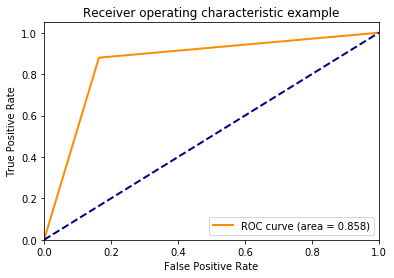

In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(test_y, predictions)
print('auc: ', auc)
print('')

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_y, predictions)
print('fpr: ', fpr)
print('tpr: ', tpr)
print('')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [ ]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir

# Similarly we will remove the files in the cache_dir directory and the directory itself
!rm $cache_dir/*
!rmdir $cache_dir